# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression (`liblinear` solver)
- performs well with sparse variables
- needs no preprocessing

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i labels' % X.shape)

# Set up base classifier
clf = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=7)

Loaded 34955 samples with 4456 labels


In [5]:
# Define objective function
def objective(params):
    _ = clf.set_params(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1', n_jobs=5).mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {'C': hp.uniform('C', 0.1, 10)}

# Begin optimization
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 100/100 [04:28<00:00,  2.99s/it, best loss: -0.7353751378839624]


{'C': 2.3114977078268453}

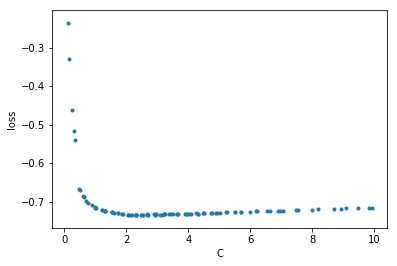

In [7]:
# Plot optimization progress: parameter vs loss
xs = [t['misc']['vals']['C'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]

_ = plt.scatter(xs, ys, marker='.')
_ = plt.xlabel('C')
_ = plt.ylabel('loss')

In [8]:
# Set up classifier
_ = clf.set_params(**best_params)
_ = clf.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9412    0.9120    0.9264     20465
           1     0.4703    0.5785    0.5188      2764

    accuracy                         0.8723     23229
   macro avg     0.7058    0.7453    0.7226     23229
weighted avg     0.8852    0.8723    0.8779     23229



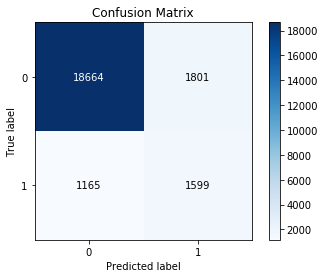

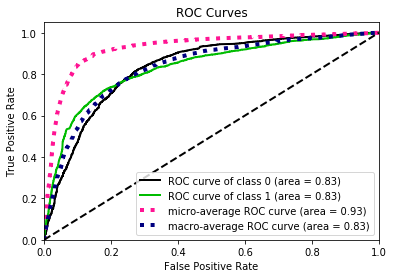

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9244    0.9600    0.9419     25490
           1     0.6092    0.4429    0.5129      3590

    accuracy                         0.8961     29080
   macro avg     0.7668    0.7014    0.7274     29080
weighted avg     0.8855    0.8961    0.8889     29080



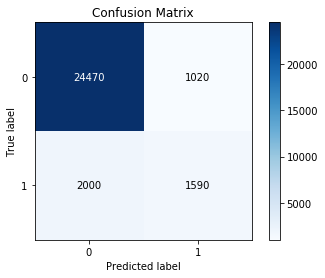

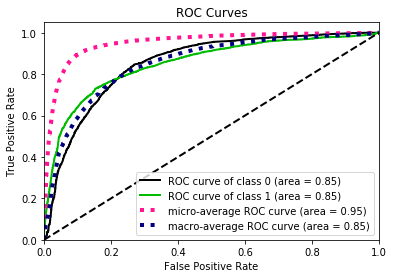

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9450    0.9636    0.9542      6620
           1     0.7720    0.6874    0.7273      1187

    accuracy                         0.9216      7807
   macro avg     0.8585    0.8255    0.8407      7807
weighted avg     0.9187    0.9216    0.9197      7807



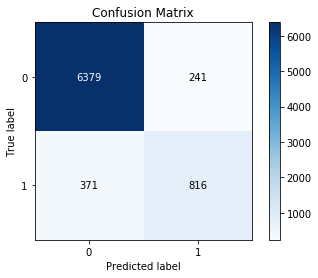

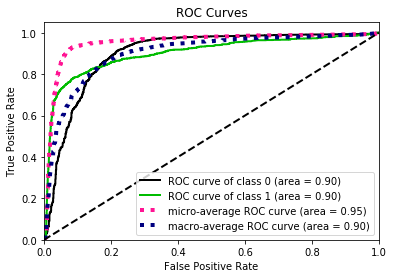

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier
    _ = clf.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))